<a href="https://colab.research.google.com/github/Ritukuklani/Deep-Learning/blob/main/hw5prob3DeepFakeImagesGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers

In [ ]:
# Load the data

(x_train,y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# Normalizing the images 

x_train = (x_train.astype(np.float32) - 127.5)/127.5
x_test = (x_test.astype(np.float32) - 127.5)/127.5

In [ ]:


BATCH_SIZE = 256
x_train_batch = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)

In [ ]:
z = 100

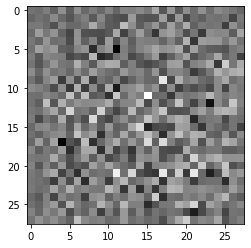

In [ ]:
# Architecture for Generator

def generator_create():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias = False, input_shape=(z,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.3))

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, kernel_size = 5, strides = 1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.3))

    model.add(layers.Conv2DTranspose(64, kernel_size = 5, strides = 2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.3))

    model.add(layers.Conv2DTranspose(1, kernel_size = 5, strides = 2, padding='same', use_bias=False, activation='tanh'))

    return model

generator = generator_create()

# generate random noise image 

noise = tf.random.normal([1, 100])
gen_img = generator(noise, training=False)

plt.imshow(gen_img[0,:,:,0], cmap='gray')

In [ ]:
# Architecture for Discriminator 

def discriminator_create():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, kernel_size = 5, strides = 2, padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size = 5, strides = 2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = discriminator_create()
decision_output = discriminator(gen_img)
print(decision_output)

tf.Tensor([[-0.0017077]], shape=(1, 1), dtype=float32)


In [ ]:
#CrossEntropyLoss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

#Generator loss
def generator_loss(fake_img):
    return cross_entropy(tf.ones_like(fake_img), fake_img)

#discriminator loss
def discriminator_loss(real, fake_img):
    d_loss_real = cross_entropy(tf.ones_like(real), real)
    d_loss_fake = cross_entropy(tf.zeros_like(fake_img), fake_img)
    d_loss = d_loss_real + d_loss_fake
    return d_loss

In [ ]:
# Adam Optimizers used for generator and discriminator

gen_optim = tf.keras.optimizers.Adam(1e-4)
dis_optim = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
z = 100
images_generated = 9
seed = tf.random.normal([images_generated, z])

In [ ]:
# Training a function to update generator and discriminator 

def train(x_train_batch):

    gen_losses = []
    dis_losses = []

    for epoch in range(EPOCHS):

        epoch_g_loss = 0
        epoch_d_loss = 0

        for img in x_train_batch:
          
            noise = tf.random.normal([BATCH_SIZE, z])

            with tf.GradientTape() as g, tf.GradientTape() as d:

                gen_img = generator(noise, training=True)

                real = discriminator(img, training=True)
                fake_img = discriminator(gen_img, training=True)

                g_loss = generator_loss(fake_img)
                d_loss = discriminator_loss(real, fake_img)

                epoch_g_loss += float(g_loss)
                epoch_d_loss += float(d_loss)

            grad_generator = g.gradient(g_loss, generator.trainable_variables)
            grad_discriminator = d.gradient(d_loss, discriminator.trainable_variables)

            gen_optim.apply_gradients(zip(grad_generator, generator.trainable_variables))
            dis_optim.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

        if (epoch == 9 or epoch == 29 or epoch == 49):
            print ('Epoch: {}'.format(epoch+1))
            print_images(generator, seed)

        gen_losses.append(epoch_g_loss / len(x_train_batch))
        dis_losses.append(epoch_d_loss / len(x_train_batch))

    return (gen_losses, dis_losses)

In [ ]:
def print_images(model, test_input):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(3, 3))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')

    plt.show()

Epoch: 10


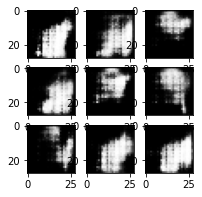

Epoch: 30


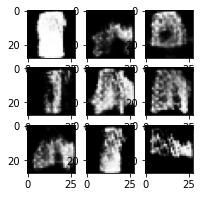

Epoch: 50


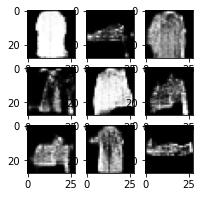

In [ ]:
gen_loss, dis_loss = train(x_train_batch)

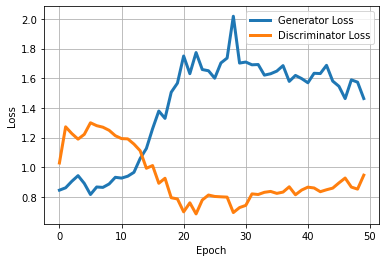

In [ ]:
plt.plot(range(50), gen_loss, '-', linewidth=3, label = 'Generator Loss')
plt.plot(range(50), dis_loss,'-',linewidth=3, label = 'Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

In the above model, we have learnt that the generator and discriminator compete against each other, so that if the generator learns to get better at generating fake images while the discriminator gets better at discriminating between real and fake images. Thus, we  need to stop the training at an equilibrium point. 